##### __Author:__ Bram Van de Sande

__Date:__ 1 MAY 2018

__Outline:__ Tutorial on how to run the full SCENIC pipeline using the python implementation (i.e. pyscenic).

For this notebook 3005 single cell transcriptomes taken from the mouse brain (somatosensory cortex and hippocampal regions) are used as an example.

> A. Zeisel, A. B. M͡oz-Manchado, S. Codeluppi, P. Lönnerberg, G. L. Manno, A. Juréus, S. Marques, H. Munguba, L. He, C. Betsholtz, C. Rolny, G. Castelo-Branco, J. Hjerling-Leffler, and S. Linnarsson, “Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq,” Science, vol. 347, no. 6226, pp. 1138–1142, Mar. 2015.

In [15]:
import pandas as pd
import numpy as np
import os, glob
import pickle

from arboretum.utils import load_tf_names
from arboretum.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

In [8]:
DATA_FOLDER="/Users/bramvandesande/Projects/lcb/tmp"
RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"

DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.mc9nr.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")

MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'mm_tfs.txt')
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "GSE60361_C1-3005-Expression.txt")

ADJACENCIES_FNAME = os.path.join(DATA_FOLDER, "adjacencies.tsv")
MODULES_FNAME = os.path.join(DATA_FOLDER, "modules.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")

N_SAMPLES = 500

# Preliminary work

### Load the expression matrix

The scRNA-Seq data is downloaded from GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361 .

In [9]:
ex_matrix = pd.read_csv(SC_EXP_FNAME, sep='\t', header=0, index_col=0).T

Remove duplicate genes.

In [10]:
ex_matrix.head()

cell_id,Tspan12,Tshz1,Fnbp1l,Adamts15,Cldn12,Rxfp1,2310042E22Rik,Sema3c,Jam2,Apbb1ip,...,Gm20826_loc1,Gm20826_loc2,Gm20877_loc2,Gm20877_loc1,Gm20865_loc4,Gm20738_loc4,Gm20738_loc6,Gm21943_loc1,Gm21943_loc3,Gm20738_loc3
1772071015_C02,0,3,3,0,1,0,0,11,1,0,...,0,0,0,0,0,0,0,0,0,0
1772071017_G12,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1772071017_A05,0,0,6,0,1,0,2,25,1,0,...,0,0,0,0,0,0,0,0,0,0
1772071014_B06,3,2,4,0,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1772067065_H06,0,2,1,0,0,0,0,10,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
ex_matrix.shape

(3005, 19972)

### Derive list of Transcription Factors(TF) for _Mus musculus_

List of known TFs for Mm was prepared (cf. notebook).

In [12]:
tf_names = load_tf_names(MM_TFS_FNAME)

### Load ranking databases

In [13]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.basename(fname).split(".")[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]

In [14]:
dbs

[FeatherRankingDatabase(name="mm9-tss-centered-10kb-10species"),
 FeatherRankingDatabase(name="mm9-500bp-upstream-7species"),
 FeatherRankingDatabase(name="mm9-500bp-upstream-10species"),
 FeatherRankingDatabase(name="mm9-tss-centered-5kb-10species"),
 FeatherRankingDatabase(name="mm9-tss-centered-10kb-7species"),
 FeatherRankingDatabase(name="mm9-tss-centered-5kb-7species")]

# Phase I: Inference of co-expression modules

In the initial phase of the pySCENIC pipeline the single cell expression profiles are used to infer co-expression modules from.

### Run GRNboost from `arboretum` to infer co-expression modules

The arboretum package is used for this phase of the pipeline.

In [12]:
adjancencies = grnboost2(expression_data=ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph
computing dask graph
shutting down client and local cluster
finished


In [13]:
adjancencies.head()

,TF,target,importance
157,Tcf7l2,Nfasc,60.207182
172,Olig1,Mbp,60.016574
157,Tcf7l2,Itpr2,59.006877
35,Rpl7,Gm9846,58.076907
155,Neurod6,Hpca,58.076307


In [10]:
adjacencies.to_csv(ADJACENCIES_FNAME, index=False, sep='\t')
#adjacencies = pd.read_csv(ADJACENCIES_FNAME, sep='\t')

### Derive potential regulomes from these co-expression modules

Regulons are derived from adjacencies based on three methods.

The first method to create the TF-modules is to select the best targets for each transcription factor:

1. Targets with importance > the 50th percentile.
2. Targets with importance > the 75th percentile
3. Targets with importance > the 90th percentile.

The second method is to select the top targets for a given TF:

1. Top 50 targets (targets with highest weight)

The alternative way to create the TF-modules is to select the best regulators for each gene (this is actually how GENIE3 internally works). Then, these targets can be assigned back to each TF to form the TF-modules. In this way we will create three more gene-sets:

1. Targets for which the TF is within its top 5 regulators
2. Targets for which the TF is within its top 10 regulators
3. Targets for which the TF is within its top 50 regulators

A distinction is made between modules which contain targets that are being activated and genes that are being repressed. Relationship between TF and its target, i.e. activator or repressor, is derived using the original expression profiles. The Pearson product-moment correlation coefficient is used to derive this information.

In addition, the transcription factor is added to the module and modules that have less than 20 genes are removed.

In [11]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))

In [11]:
with open(MODULES_FNAME, 'wb') as f:
    pickle.dump(modules, f)

#with open(MODULES_FNAME, 'rb') as f:
#    modules = pickle.load(f)

# Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)

In [13]:
df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

Using 8 workers.
2018-03-07 13:10:30.850754 - Worker mm9-tss-centered-10kb-10species(2): database loaded in memory.
2018-03-07 13:10:31.182540 - Worker mm9-tss-centered-10kb-10species(4): database loaded in memory.
2018-03-07 13:10:31.247187 - Worker mm9-tss-centered-10kb-10species(1): database loaded in memory.
2018-03-07 13:10:31.245944 - Worker mm9-tss-centered-10kb-10species(3): database loaded in memory.
2018-03-07 13:10:33.713656 - Worker mm9-tss-centered-10kb-10species(2): motif annotations loaded in memory.
2018-03-07 13:10:33.714281 - Worker mm9-tss-centered-10kb-10species(1): motif annotations loaded in memory.
2018-03-07 13:10:33.715242 - Worker mm9-tss-centered-10kb-10species(3): motif annotations loaded in memory.
2018-03-07 13:10:33.716182 - Worker mm9-tss-centered-10kb-10species(4): motif annotations loaded in memory.
2018-03-07 13:10:34.963628 - Worker mm9-500bp-upstream-7species(4): database loaded in memory.
2018-03-07 13:10:35.256590 - Worker mm9-500bp-upstream-7spec

In [15]:
df.head()

Enrichment            \
                                                AUC       NES   
TF    MotifID                                                   
Kdm5a cisbp__M4603                         0.035354  3.062696   
      dbcorrdb__NR2C2__ENCSR000EVS_1__m1   0.038906  4.577160   
      cisbp__M4568                         0.042070  5.925836   
      dbcorrdb__SIN3A__ENCSR000BGL_1__m1   0.040095  5.084047   
      dbcorrdb__NR2C2__ENCSR000EVN_1__m1   0.036591  3.589996   

                                                                \
                                         MotifSimilarityQvalue   
TF    MotifID                                                    
Kdm5a cisbp__M4603                                    0.000000   
      dbcorrdb__NR2C2__ENCSR000EVS_1__m1              0.000941   
      cisbp__M4568                                    0.000324   
      dbcorrdb__SIN3A__ENCSR000BGL_1__m1              0.000314   
      dbcorrdb__NR2C2__ENCSR000EVN_1__m1              0.000637   

                                                              \
                                         OrthologousIdentity   
TF    MotifID                                                  
Kdm5a cisbp__M4603                                  0.966864   
      dbcorrdb__NR2C2__ENCSR000EVS_1__m1            0.966864   
      cisbp__M4568                                  0.966864   
      dbcorrdb__SIN3A__ENCSR000BGL_1__m1            0.966864   
      dbcorrdb__NR2C2__ENCSR000EVN_1__m1            0.966864   

                                                                                             \
                                                                                 Annotation   
TF    MotifID                                                                                 
Kdm5a cisbp__M4603                        gene is orthologous to ENSG00000073614 in H. s...   
      dbcorrdb__NR2C2__ENCSR000EVS_1__m1  motif similar to dbcorrdb__KDM5A__ENCSR000AQL_...   
      cisbp__M4568                        motif similar to dbcorrdb__KDM5A__ENCSR000AQL_...   
      dbcorrdb__SIN3A__ENCSR000BGL_1__m1  motif similar to dbcorrdb__KDM5A__ENCSR000AQL_...   
      dbcorrdb__NR2C2__ENCSR000EVN_1__m1  motif similar to dbcorrdb__KDM5A__ENCSR000AQL_...   

                                                                                             \
                                                                                    Context   
TF    MotifID                                                                                 
Kdm5a cisbp__M4603                        (mm9-tss-centered-10kb-10species, weight>0.001...   
      dbcorrdb__NR2C2__ENCSR000EVS_1__m1  (mm9-tss-centered-10kb-10species, weight>0.001...   
      cisbp__M4568                        (mm9-tss-centered-10kb-10species, weight>0.001...   
      dbcorrdb__SIN3A__ENCSR000BGL_1__m1  (mm9-tss-centered-10kb-10species, weight>0.001...   
      dbcorrdb__NR2C2__ENCSR000EVN_1__m1  (mm9-tss-centered-10kb-10species, weight>0.001...   

                                                                                             \
                                                                                TargetGenes   
TF    MotifID                                                                                 
Kdm5a cisbp__M4603                        [(Yy1, 1.0), (Bscl2, 1.0), (Tra2b, 1.0), (Cxxc...   
      dbcorrdb__NR2C2__ENCSR000EVS_1__m1  [(Larp4, 1.0), (Zfp384, 1.0), (Psma6, 1.0), (Z...   
      cisbp__M4568                        [(Zfp384, 1.0), (Psmd13, 1.0), (Fam188a, 1.0),...   
      dbcorrdb__SIN3A__ENCSR000BGL_1__m1  [(Zfp384, 1.0), (Egr1, 1.0), (Vps52, 1.0), (Tr...   
      dbcorrdb__NR2C2__ENCSR000EVN_1__m1  [(Larp4, 1.0), (Gas5, 1.0), (Psma6, 1.0), (Zfp...   

                                                    
                                         RankAtMax  
TF    MotifID                                       
Kdm5a cisbp__M4603                  

In [14]:
df.to_csv(MOTIFS_FNAME)

This dataframe can then be converted to regulons.

In [16]:
regulons = df2regulons(df)

In [10]:
with open(REGULONS_FNAME, 'wb') as f:
    pickle.dump(regulons, f)

#with open(REGULONS_FNAME, 'rb') as f:
#    regulons = pickle.load(f)

# Phase III: Cellular regulon enrichment matrix (aka AUCell)

Characterize the different cells in a single-cell transcriptomics experiment by the enrichment of the regulons. Enrichment of a regulon is measures as AUC of the recovery curve of the genes that define this regulon.

In [ ]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=1)

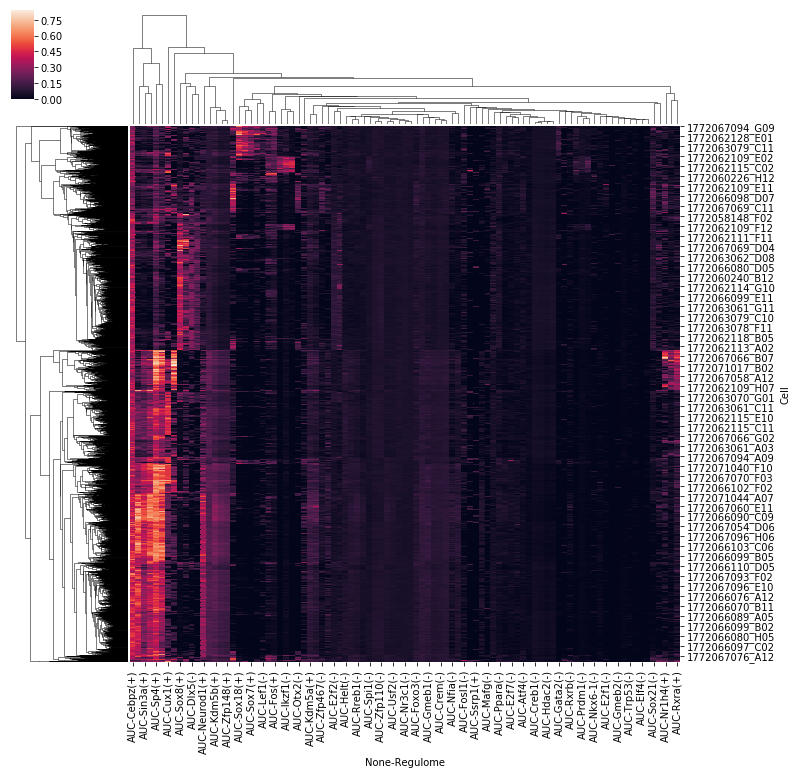

In [14]:
sns.clustermap(auc_mtx, figsize=(12,12))